# Predicting Customer Churn Using Supervised Machine Learning

This notebook investigates whether customer churn can be predicted using supervised machine learning models applied to structured tabular data.

The objective is to:
- Build at least two classification models
- Compare their performance
- Select a final model based on appropriate evaluation metrics
- Interpret the results in a business context

Dataset: Telco Customer Churn (Kaggle)


In [2]:
# Import necessary libraries for data manipulation, visualisation and modelling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    RocCurveDisplay,
    classification_report
)

# For cleaner notebook output
import warnings
warnings.filterwarnings("ignore")

print("Libraries successfully imported.")


Libraries successfully imported.


In [3]:
# Load dataset
# The file is stored inside the data folder

df = pd.read_csv("../data/churn.csv")

# Remove any hidden whitespace in column names
df.columns = df.columns.str.strip()

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7032 non-null   int64  
 1   tenure                                 7032 non-null   int64  
 2   MonthlyCharges                         7032 non-null   float64
 3   TotalCharges                           7032 non-null   float64
 4   Churn                                  7032 non-null   int64  
 5   gender_Male                            7032 non-null   bool   
 6   Partner_Yes                            7032 non-null   bool   
 7   Dependents_Yes                         7032 non-null   bool   
 8   PhoneService_Yes                       7032 non-null   bool   
 9   MultipleLines_No phone service         7032 non-null   bool   
 10  MultipleLines_Yes                      7032 non-null   bool   
 11  InternetS

In [4]:
# Quick overview of dataset structure

df.info()

# Check class distribution
df["Churn"].value_counts(normalize=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

In [5]:
# Convert TotalCharges to numeric
# Some rows contain blank spaces, so errors='coerce' converts them to NaN

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Drop rows with missing values
# Given the small number of missing rows, removal is unlikely to bias results significantly

df.dropna(inplace=True)

# Drop customerID as it does not provide predictive value
df.drop("customerID", axis=1, inplace=True)

# Convert target variable to binary (1 = churn, 0 = retained)
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

print("Cleaned dataset shape:", df.shape)



Cleaned dataset shape: (7032, 20)


In [6]:
# Convert categorical variables using one-hot encoding
# drop_first=True prevents multicollinearity in linear models

df = pd.get_dummies(df, drop_first=True)

print("Dataset shape after encoding:", df.shape)



Dataset shape after encoding: (7032, 31)


In [7]:
# Separate predictors (X) and target variable (y)

X = df.drop("Churn", axis=1)
y = df["Churn"]

print("Feature matrix shape:", X.shape)
print("Target distribution:\n", y.value_counts(normalize=True))



Feature matrix shape: (7032, 30)
Target distribution:
 Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64


In [8]:
# Split into training and test sets
# Stratify ensures churn proportion remains consistent across both sets

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training size:", X_train.shape)
print("Test size:", X_test.shape)



Training size: (5625, 30)
Test size: (1407, 30)


In [9]:
# Logistic Regression is used as a baseline model.
# Since this is a linear model, feature scaling is required.

scaler = StandardScaler()

# Fit scaler on training data only (to avoid data leakage)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialise Logistic Regression
# class_weight="balanced" helps account for class imbalance

log_model = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    random_state=42
)

# Train the model
log_model.fit(X_train_scaled, y_train)

print("Logistic Regression model trained successfully.")


Logistic Regression model trained successfully.


In [10]:
# Generate predictions
y_pred_log = log_model.predict(X_test_scaled)
y_prob_log = log_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate performance
print("=== Logistic Regression Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Precision:", precision_score(y_test, y_pred_log))
print("Recall:", recall_score(y_test, y_pred_log))
print("F1-score:", f1_score(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_log))


=== Logistic Regression Performance ===
Accuracy: 0.7263681592039801
Precision: 0.49093904448105435
Recall: 0.7967914438502673
F1-score: 0.6075433231396534
ROC-AUC: 0.8349765233911922


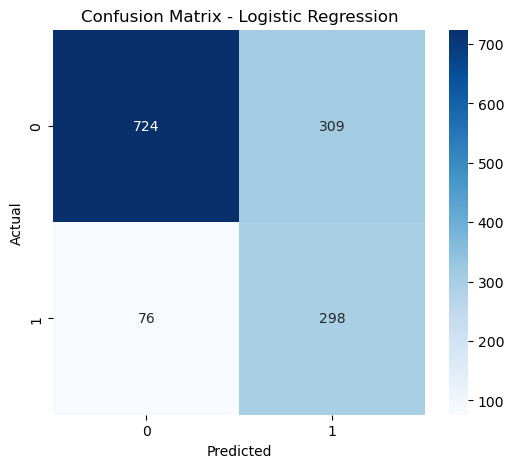

In [11]:
# Confusion Matrix for Logistic Regression

cm_log = confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(6,5))
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [12]:
# Random Forest is an ensemble model that can capture non-linear relationships.
# Unlike Logistic Regression, scaling is not required for tree-based models.

rf_model = RandomForestClassifier(
    random_state=42,
    class_weight="balanced"
)

# Train model
rf_model.fit(X_train, y_train)

print("Random Forest model trained successfully.")


Random Forest model trained successfully.


In [13]:
# Generate predictions
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate performance
print("=== Random Forest Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1-score:", f1_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))



=== Random Forest Performance ===
Accuracy: 0.7924662402274343
Precision: 0.6404109589041096
Recall: 0.5
F1-score: 0.5615615615615616
ROC-AUC: 0.8159946368761357


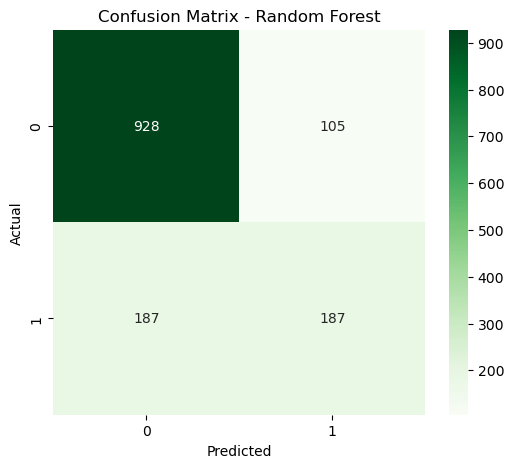

In [14]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



In [15]:
# Compare Logistic Regression and Random Forest

results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_rf)
    ],
    "Precision": [
        precision_score(y_test, y_pred_log),
        precision_score(y_test, y_pred_rf)
    ],
    "Recall": [
        recall_score(y_test, y_pred_log),
        recall_score(y_test, y_pred_rf)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, y_prob_log),
        roc_auc_score(y_test, y_prob_rf)
    ]
})

results



,Model,Accuracy,Precision,Recall,ROC-AUC
0,Logistic Regression,0.726368,0.490939,0.796791,0.834977
1,Random Forest,0.792466,0.640411,0.500000,0.815995


In [16]:
# Hyperparameter tuning for Random Forest
# We optimise based on ROC-AUC since class imbalance exists

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

grid_search = GridSearchCV(
    RandomForestClassifier(
        random_state=42,
        class_weight="balanced"
    ),
    param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}


In [17]:
# Use the best estimator from GridSearch

best_rf = grid_search.best_estimator_

y_pred_best = best_rf.predict(X_test)
y_prob_best = best_rf.predict_proba(X_test)[:, 1]

print("=== Tuned Random Forest Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Precision:", precision_score(y_test, y_pred_best))
print("Recall:", recall_score(y_test, y_pred_best))
print("F1-score:", f1_score(y_test, y_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_best))


=== Tuned Random Forest Performance ===
Accuracy: 0.7647476901208244
Precision: 0.5415860735009671
Recall: 0.7486631016042781
F1-score: 0.6285072951739619
ROC-AUC: 0.8359290473207674


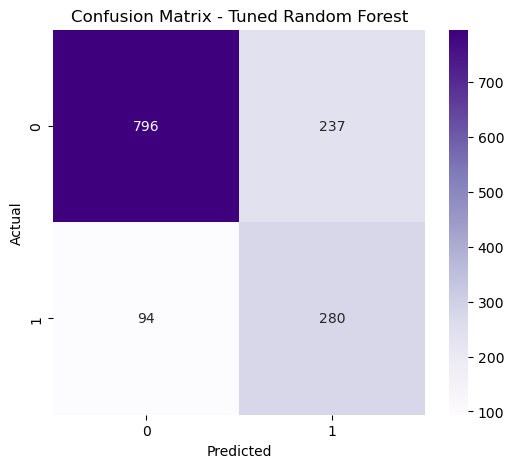

In [18]:
cm_best = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,5))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - Tuned Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [19]:
# Perform cross-validation on the final model
# This helps assess stability across different folds

cv_scores = cross_val_score(
    best_rf,
    X_train,
    y_train,
    cv=5,
    scoring="roc_auc"
)

print("Cross-Validated ROC-AUC Scores:", cv_scores)
print("Mean ROC-AUC:", cv_scores.mean())


Cross-Validated ROC-AUC Scores: [0.84020585 0.86342692 0.84925134 0.81909432 0.84775928]
Mean ROC-AUC: 0.8439475410367082


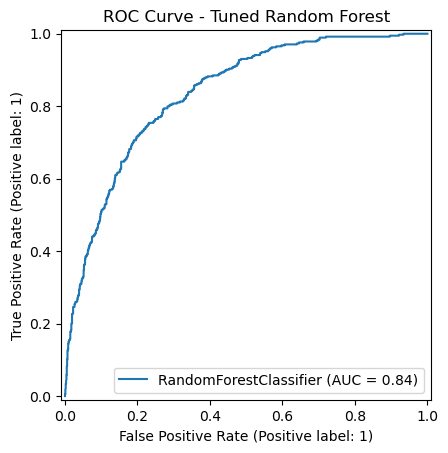

In [20]:
RocCurveDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("ROC Curve - Tuned Random Forest")
plt.show()


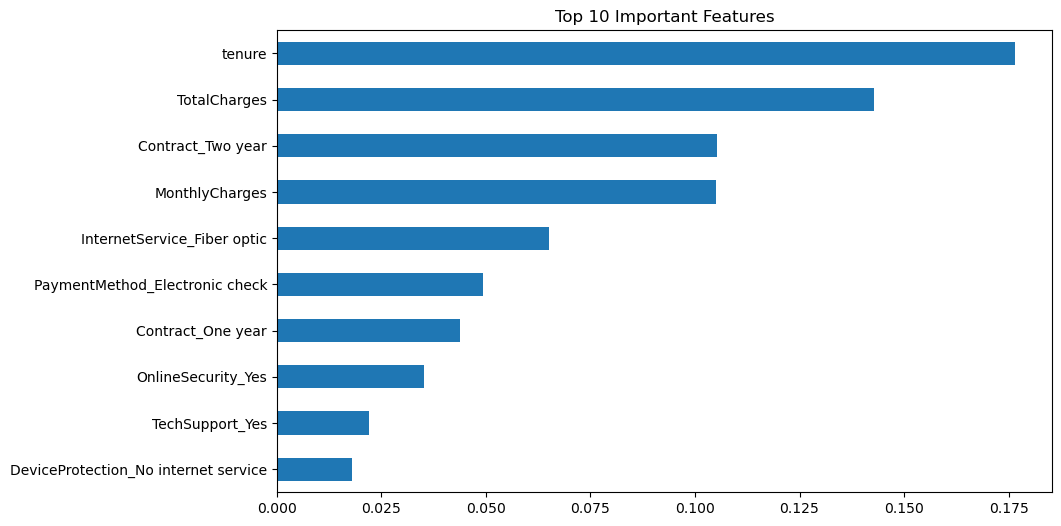

tenure                                  0.176523
TotalCharges                            0.142839
Contract_Two year                       0.105265
MonthlyCharges                          0.105010
InternetService_Fiber optic             0.065112
PaymentMethod_Electronic check          0.049206
Contract_One year                       0.043889
OnlineSecurity_Yes                      0.035177
TechSupport_Yes                         0.022121
DeviceProtection_No internet service    0.018053
dtype: float64

In [21]:
# Analyse which features contribute most to predictions

importances = pd.Series(
    best_rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(10,6))
importances.head(10).plot(kind="barh")
plt.title("Top 10 Important Features")
plt.gca().invert_yaxis()
plt.show()

importances.head(10)


## Final Model Selection

Although the untuned Random Forest achieved the highest raw accuracy,
the tuned Random Forest was selected as the final model because it
achieved a better balance between recall and precision.

Given that false negatives represent customers who churn without
intervention, prioritising recall was considered strategically
appropriate. The tuned model also achieved the highest ROC-AUC,
indicating strong discriminative performance.

Therefore, the tuned Random Forest provides the most suitable balance
between predictive performance and practical applicability.
